# Games Project

**The goal**:
- To identify the patterns that determine the success of the game
- This will allow to get an understanding on a potentially popular product and plan advertising campaigns

**Input data**: 
- Games sales data up to 2016 year
- 2016 year is not full
- ESRB (Entertainment Software Rating Board) is an association that determines the age rating of computer games

**Analysis structure**:
* Data overview
* Data preparation
* Data analysis
* Hypothesis testing
* Results

## Data overview

In [629]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

In [630]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('games.csv')

In [631]:
# set floats formats (in order not to see scientific notation)
pd.options.display.float_format = '{:.2f}'.format

In [632]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.00,Platform,11.28,9.14,6.50,2.88,89.00,8.5,E
7,Wii Play,Wii,2006.00,Misc,13.96,9.18,2.93,2.84,58.00,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.00,Platform,14.44,6.94,4.70,2.24,87.00,8.4,E
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [633]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


There are 11 columns in the dataframe:

`Name` - the name of the game; `object`  
`Platform` - platform of the game; `object`  
`Year_of_Release` - year of release; `float`  
`Genre` - game genre; `object`  
`NA_sales` - sales in North America (millions of copies sold); `float`  
`EU_sales` - sales in Europe (millions of copies sold); `float`  
`JP_sales` - sales in Japan (millions of copies sold); `float`  
`Other_sales` - sales in other countries (millions of copies sold); `float`  
`Critic_Score` - critics score (maximum 100); `float`  
`User_Score` - user score (maximum 10); `object`  
`Rating` - rating from the ESRB (Entertainment Software Rating Board); `object`  

As we can see, there are definetely missing data in some columns.

<AxesSubplot:title={'center':'Proportion of missing values'}>

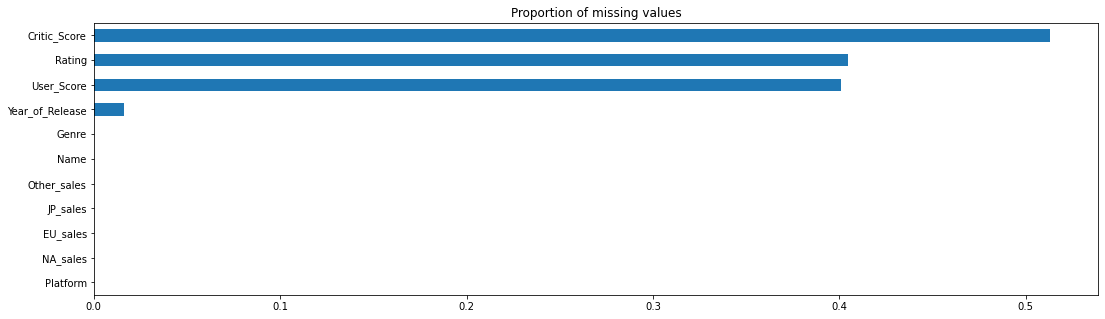

In [634]:
# create a chart with missing values

(
    df
     .isna()
     .mean()
     .sort_values(ascending=True)
     .plot(kind='barh', figsize=(18,5), legend=False, title='Proportion of missing values')
)

Findings:

- The biggest portion of missing values is in `critic_score`: more than 50% of inputs
- Both `rating` and `user_score` are missing around 40% of inputs
- The year of game release is missing in less than 2% of cases

We do not know the exact reason behind such high proportions of missing values but below are some thoughts:
  
- It can be simply a technical mistake while downloading from database
- It can be that the user and critics involvment into those games is low, meaning they are not very proactive to give the scores

In [635]:
# general check for full duplicates

df.duplicated().sum()

0

## Data preparation

### Changing registers

In [636]:
# rename columns to lower case
df.columns = df.columns.str.lower()

In [637]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Changing data types

In [638]:
# in order to change data types for years we cut the df with missing values in years

df = df.dropna(subset=['year_of_release'])

In [639]:
# change type for the year of game release

df['year_of_release'] = df['year_of_release'].astype('int64')

There are some scores in `user_score` marked as 'tbd' which we suppose mean 'to be determined' which can be treated as a missing value.  
So we change those for `NaN` in order to change the data type further.  



In [640]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)

In [641]:
df['user_score'].isna().mean()

0.5462118448254895

This brings the portion of missing values for `user_score` up to almost 55%.

In [642]:
# change type for user scores

df['user_score'] = df['user_score'].astype('float64')

### Missing values


In [643]:
# check missing genres

df[df['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


As we can see, the rows where the `genre` is missing also includes the missing `name` so we decide just to drop those rows.

In [644]:
df = df.dropna(subset=['genre'])

In [645]:
# filling missing ESRB rating with no meaning word in order to see in analysis further on 

df['rating'] = df['rating'].fillna('no_esrb')

For other columns and missing values in them, we do not see any option to fill the ones as:
- `critic_score` and `user_score` are very subjective values
- filling `year_of_release` with any agg function does not bring sense

So we just leave the missing values as it is

### Calculating total sales


In [646]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis='columns')

## Data analysis

### Years of release


<AxesSubplot:title={'center':'Number of games released in a year'}, xlabel='year_of_release'>

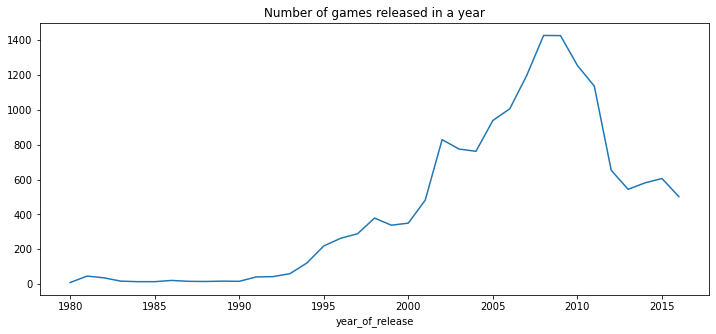

In [648]:
# calc how many games were released in each year and plot

(
    df
    .groupby('year_of_release')['name']
    .count()
    .plot(title='Number of games released in a year', figsize=(12,5))
)

Data clearly shows 4 periods:
1) 1980-1993: almost same number of games released in a year  
2) 1993-2000: steady growth of number of games released  
3) 2000-2008: huge growth of releases with peak around 1400 games in a year  
4) 2009-now: strong downwards

Some thoughts about the periods above:

1) Industry was just borning: Platforms were expensive, meaning less people could afford playing; there were not so many platforms and games developers  
2) Industry develops: Both the demand and supply start to accelerate  
3) Industry makes a big jump: strong demand due to cheaper platforms, games availability and wider options + supply is super strong  
4) Industry decreases: starting from 2009 the mobile games start to overtake platforms, and then especially after the strong adoption of smartphone after first iPhone releases, the mobile (and mobile games) are the modern power growth

### Platforms


<AxesSubplot:title={'center':'Change over time in platforms for all years'}, xlabel='year_of_release'>

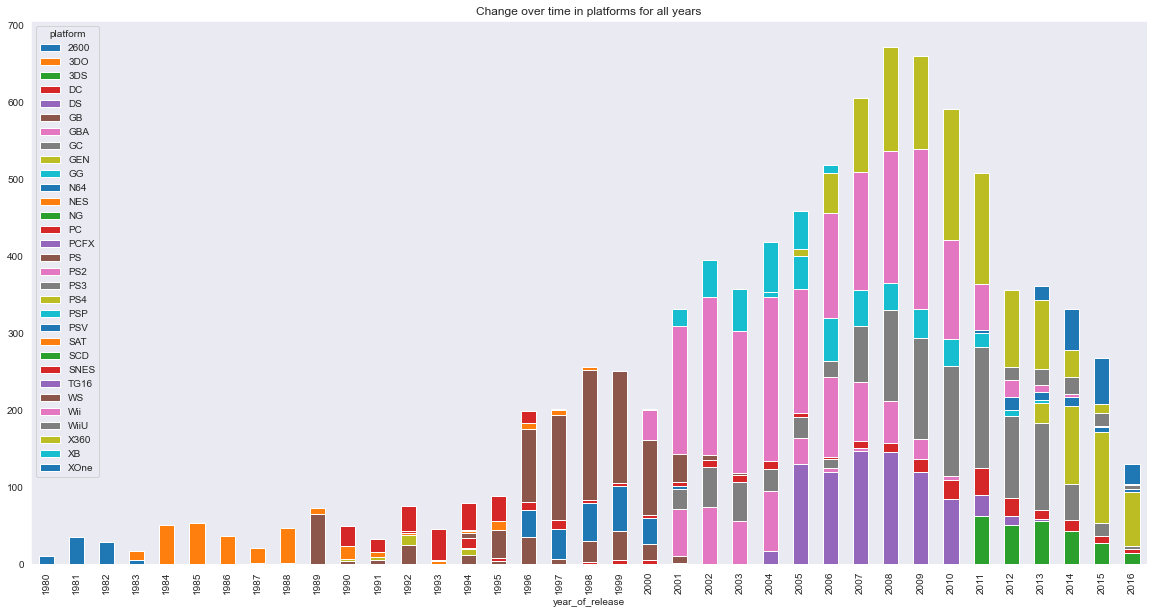

In [713]:
# change over time in platforms for all years

(
    df
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot
    .bar(stacked=True, figsize=(20,10), title='Change over time in platforms for all years')
)

The graph above proves the periods we highlighted before.

<AxesSubplot:title={'center':'top 5 biggest platforms by total sales over years'}, xlabel='platform'>

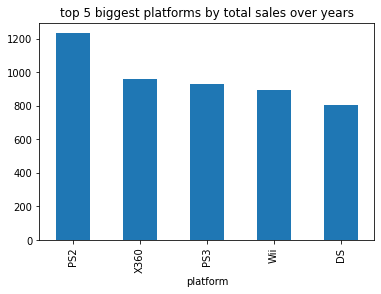

In [21]:
# top 5 biggest platforms by total sales over years

(
    df
    .groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .plot
    .bar(title='top 5 biggest platforms by total sales over years')
)

<AxesSubplot:title={'center':'Change over years for 5 biggest platforms by total sales'}, xlabel='year_of_release'>

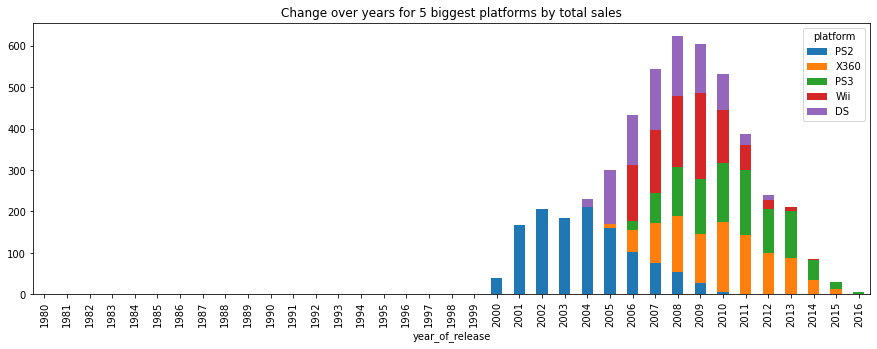

In [22]:
# change over years for 5 biggest platforms by total sales

df_top_5 = pd.DataFrame(df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).reset_index())
df_top_5_names = df_top_5['platform'].values.tolist()

(
    df
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')[df_top_5_names]
    .plot
    .bar(stacked=True, figsize=(15,5), title='Change over years for 5 biggest platforms by total sales')
)

Visually we see that top 5 platforms "live" on average around 7 years.  
We check for all the platform for all the years as well.

In [23]:
# check average life of a platform

(
    df
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .count()
    .mean()
)

7.67741935483871

The data proves our visual findings almost perfectly.  
So, on average the platform is generating sales for **7,7 years**.

**Understanding the actual timeframe for further analysis**

First, we check the most popular platforms in 2016.

In [24]:
df_2016 = df[df['year_of_release'] == 2016]

In [25]:
df_2016.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS4    69.25
XOne   26.15
3DS    15.14
PC      5.25
WiiU    4.60
PSV     4.25
PS3     3.60
X360    1.52
Wii     0.18
Name: total_sales, dtype: float64

Top 3 platforms are "PS4", "XOne", and "3DS".  
We check their 'lifes' in order to see in what stage they are.

<AxesSubplot:title={'center':'Change over years for 3 biggest platforms by total sales in 2016'}, xlabel='year_of_release'>

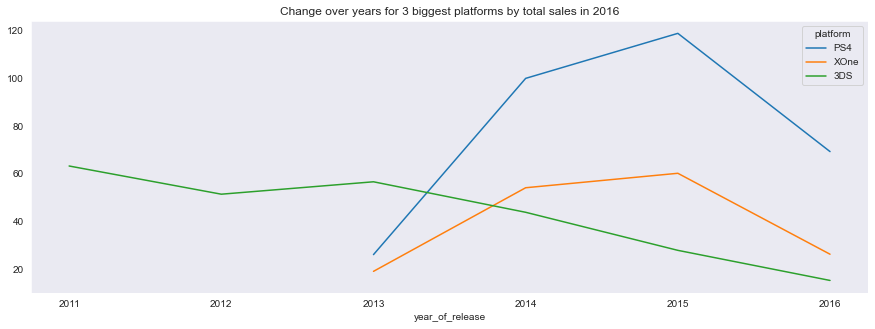

In [714]:
df_2016_top_3 = pd.DataFrame(
                            df_2016
                            .groupby('platform')['total_sales']
                            .sum()
                            .sort_values(ascending=False)
                            .head(3)
                            .reset_index()
                            )

df_2016_top_3_names = df_2016_top_3['platform'].values.tolist()

(
    df
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')[df_2016_top_3_names]
    .plot(figsize=(15,5), title='Change over years for 3 biggest platforms by total sales in 2016')
)

So, for further analysis we take the data starting **2013** where our top current platforms started sales.  
This is 4 years timeframe which is in line with the above findings of average life of 7,7 years due to:
- data for 2016 year is not full
- the distribution over the years is pretty normal, meaning exactly half of platform 'life' is growth, and the other half is then the decrease

In [27]:
# "a" stands for analysis 

df_a = df[df['year_of_release'] > 2012]

### Actual timeframe


In [28]:
# check leading platforms

df_a.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS4    314.14
PS3    181.43
XOne   159.32
3DS    143.25
X360   136.80
WiiU    64.63
PC      39.43
PSV     32.99
Wii     13.66
PSP      3.50
DS       1.54
Name: total_sales, dtype: float64

Top 5 platforms in the actual timeframe are 'PS4', 'PS3', 'XOne', '3DS', and 'X360'.  
We check how they perform over the years.

<AxesSubplot:xlabel='year_of_release'>

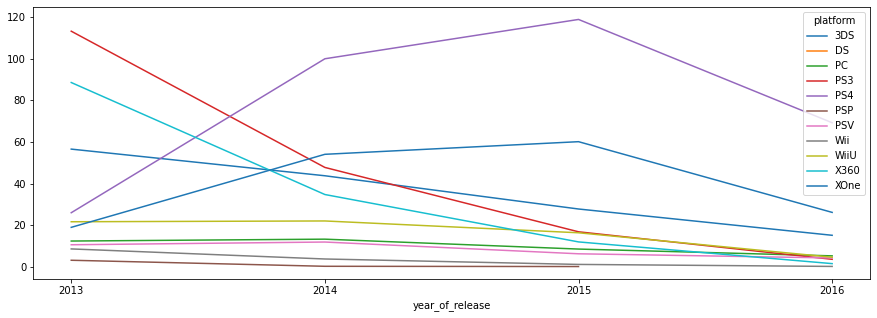

In [29]:
ticks = np.arange(2013, 2017, 1)

(
    df_a
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot(figsize=(15,5), xticks=ticks)
)

Almost all platforms are heading downwards.
The prospective platforms are the ones that still generate the most sales: **"PS4" and "XOne"**  
  
It is hard to say about the profitability of the platforms as we do not have data for sales and costs


<AxesSubplot:title={'center':'total_sales'}, xlabel='platform'>

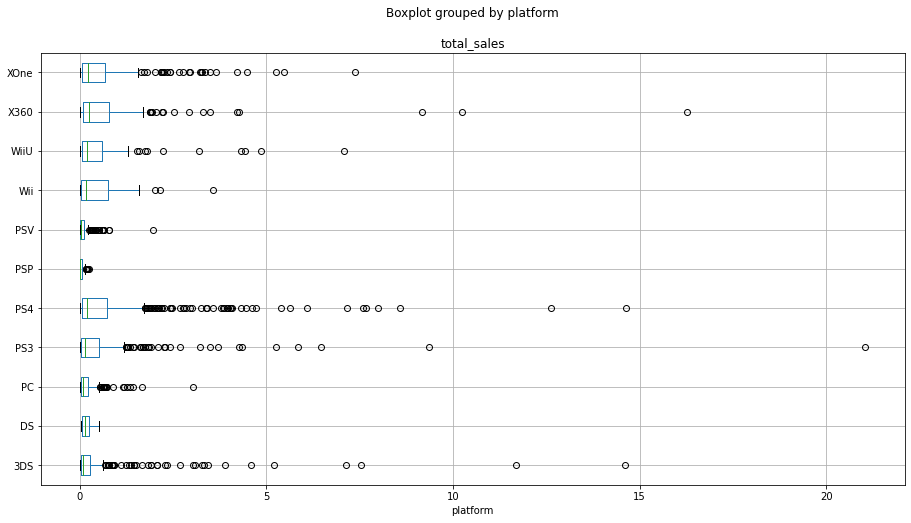

In [30]:
# creating boxplots for platforms

df_a.boxplot('total_sales', by = 'platform', figsize = (15,8), vert=False)

In the graph above the outliers are super strong, so we look deeper at prospective platforms and we cut the outliers.

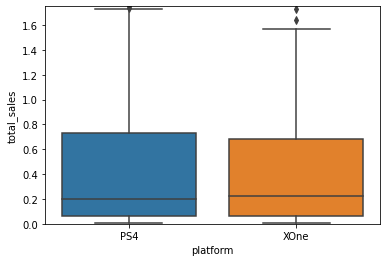

In [31]:
data = df_a.query('platform == "PS4" or platform == "XOne"')
ax = sns.boxplot(x='platform', y='total_sales', data=data)
plt.ylim(0,1.75)
plt.show()

**Looking deeper into "PS4" platform**

In [32]:
# calc correlations among scores and sales for "PS4"

df_a.query('platform == "PS4"')[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.00,0.56,0.41
user_score,0.56,1.00,-0.03
total_sales,0.41,-0.03,1.00


<AxesSubplot:title={'center':'Total sales vs Critic score for PS4 platform'}, xlabel='critic_score', ylabel='total_sales'>

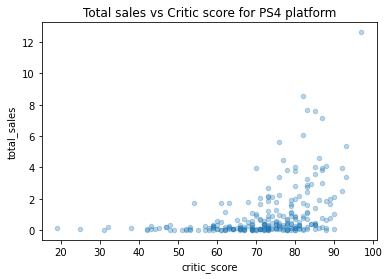

In [33]:
(
    df_a
    .query('platform == "PS4"')
    .plot(kind='scatter', x='critic_score', y='total_sales', alpha=0.3, title='Total sales vs Critic score for PS4 platform')
)

<AxesSubplot:title={'center':'Total sales vs User score for PS4 platform'}, xlabel='user_score', ylabel='total_sales'>

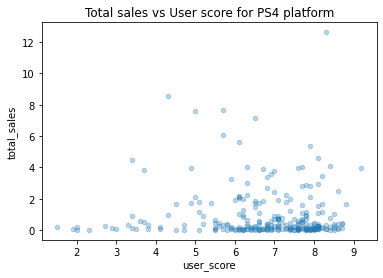

In [34]:
(
    df_a
    .query('platform == "PS4"')
    .plot(kind='scatter', x='user_score', y='total_sales', alpha=0.3, title='Total sales vs User score for PS4 platform')
)

Some findings:
- Total sales show stronger linear dependence with critics scores rather than with user scores
- The scatter plot with user scores shows pretty noisy data confirming the correlation values
- For both the critics and user scores there almost no 10 or 100 scores

**Looking deeper into other platforms (excluding PS4)**

In [35]:
# calc correlations among scores and sales for "PS4"

df_a.query('platform != "PS4"')[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.00,0.48,0.28
user_score,0.48,1.00,-0.00
total_sales,0.28,-0.00,1.00


<AxesSubplot:title={'center':'Total sales vs Critic score for other platforms'}, xlabel='critic_score', ylabel='total_sales'>

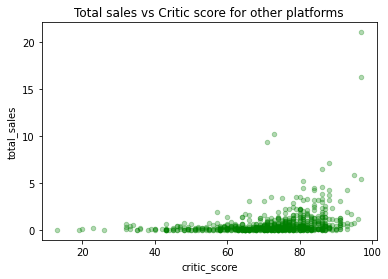

In [36]:
(
    df_a
    .query('platform != "PS4"')
    .plot(kind='scatter', 
          x='critic_score', 
          y='total_sales', 
          alpha=0.3,
          color='g',
          title='Total sales vs Critic score for other platforms')
)

<AxesSubplot:title={'center':'Total sales vs User score for other platforms'}, xlabel='user_score', ylabel='total_sales'>

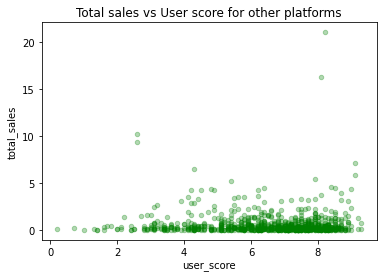

In [37]:
(
    df_a
    .query('platform != "PS4"')
    .plot(kind='scatter', 
          x='user_score', 
          y='total_sales', 
          alpha=0.3,
          color='g',
          title='Total sales vs User score for other platforms')
)

Findings:
- Compared to "PS4" platform, other platforms' total sales show even weaker linear dependences with critics and users scores

### Genres


In [682]:
# group by genres

genre_group = (
    df_a
    .groupby('genre')['total_sales']
    .agg(['sum', 'count', 'mean'])
    .sort_values(by='sum', ascending=False)
    .reset_index()
                )

Text(0.5, 1.0, 'Total sales and average sales across genres')

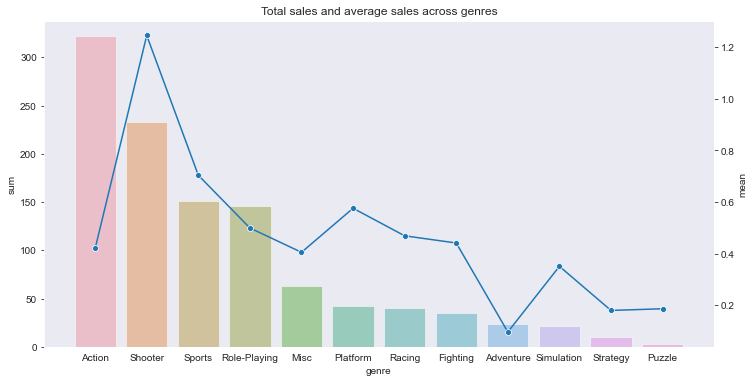

In [685]:
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(data = genre_group, x='genre', y='sum', alpha=0.5, ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data = genre_group['mean'], marker='o', sort = False, ax=ax2)
ax1.set_title('Total sales and average sales across genres')

Findings:
- The top genres by total sales are: Action, Shooter, Sports, Role-playing, and Misc
- There should be more attention given to **Shooter** as it generates the highest sales per game

### Regional analysis


#### Platforms

In [691]:
# getting 5 top platforms for each region

top_5_platforms = {}

for x in ['na_sales', 'eu_sales', 'jp_sales']:
    top_5_platforms[x] = df_a.groupby('platform')[x].sum().sort_values(ascending=False).head(5)
    
top_5_platforms

{'na_sales': platform
 PS4    108.74
 XOne    93.12
 X360    81.66
 PS3     63.50
 3DS     38.20
 Name: na_sales, dtype: float64,
 'eu_sales': platform
 PS4    141.09
 PS3     67.81
 XOne    51.59
 X360    42.52
 3DS     30.96
 Name: eu_sales, dtype: float64,
 'jp_sales': platform
 3DS    67.81
 PS3    23.35
 PSV    18.59
 PS4    15.96
 WiiU   10.88
 Name: jp_sales, dtype: float64}

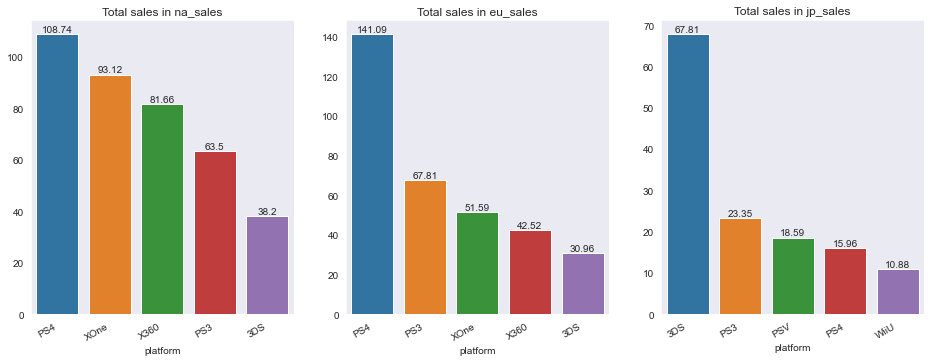

In [706]:
# creating subplots to compare visually

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
fig.autofmt_xdate();

i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']

for i in range(3):
    labels = top_5_platforms[region[i]].index
    values = top_5_platforms[region[i]].values
    ax = x[i]
    ax.set_title(f'Total sales in {region[i]}')
    sns.barplot(x=labels, y=values, ax=ax)
    ax.bar_label(ax.containers[0])
    
plt.show()

**Findings**:
- PS4, XOne, and X360 are the biggest platforms in North America
- PS4, PS3 (suprisingly), and XOne are the biggest platforms in Europe
- Japan game sales differ significantly from North America and Europe
- 3DS (having almost half of top 5 sales), PS3, and PSV are the biggest platforms in Japan

#### Genres

In [708]:
# getting 5 top genres for each region

top_5_genres = {}

for x in ['na_sales', 'eu_sales', 'jp_sales']:
    top_5_genres[x] = df_a.groupby('genre')[x].sum().sort_values(ascending=False).head(5)
    
top_5_genres

{'na_sales': genre
 Action         126.05
 Shooter        109.74
 Sports          65.27
 Role-Playing    46.40
 Misc            27.49
 Name: na_sales, dtype: float64,
 'eu_sales': genre
 Action         118.13
 Shooter         87.86
 Sports          60.52
 Role-Playing    36.97
 Racing          20.19
 Name: eu_sales, dtype: float64,
 'jp_sales': genre
 Role-Playing   51.04
 Action         40.49
 Misc            9.20
 Fighting        7.65
 Shooter         6.61
 Name: jp_sales, dtype: float64}

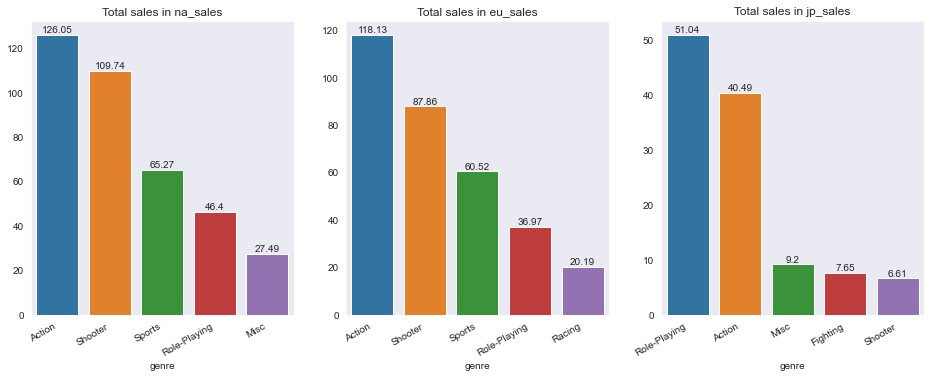

In [709]:
# creating subplots to compare visually

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
fig.autofmt_xdate();

i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']

for i in range(3):
    labels = top_5_genres[region[i]].index
    values = top_5_genres[region[i]].values
    ax = x[i]
    ax.set_title(f'Total sales in {region[i]}')
    sns.barplot(x=labels, y=values, ax=ax)
    ax.bar_label(ax.containers[0])
    
plt.show()

**Findings**:

- Action, Shooter, and Sports are the most sold genres in North America
- The same is in Europe as in North America
- Role-playing and Action are way the most sold genres in Japan

#### ESRB Rating

In [710]:
# getting 5 top ratings for each region

top_5_ratings = {}

for x in ['na_sales', 'eu_sales', 'jp_sales']:
    top_5_ratings[x] = df_a.groupby('rating')[x].sum().sort_values(ascending=False).head(5)
    
top_5_ratings

{'na_sales': rating
 M         165.21
 no_esrb    89.42
 E          79.05
 E10+       54.24
 T          49.79
 Name: na_sales, dtype: float64,
 'eu_sales': rating
 M         145.32
 E          83.36
 no_esrb    78.91
 E10+       42.69
 T          41.95
 Name: eu_sales, dtype: float64,
 'jp_sales': rating
 no_esrb   85.05
 T         20.59
 E         15.14
 M         14.11
 E10+       5.89
 Name: jp_sales, dtype: float64}

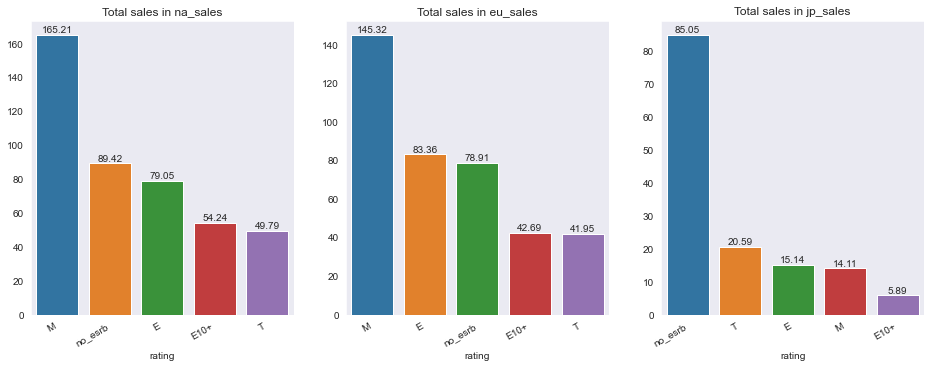

In [711]:
# creating subplots to compare visually

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
fig.autofmt_xdate();

i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']

for i in range(3):
    labels = top_5_ratings[region[i]].index
    values = top_5_ratings[region[i]].values
    ax = x[i]
    ax.set_title(f'Total sales in {region[i]}')
    sns.barplot(x=labels, y=values, ax=ax)
    ax.bar_label(ax.containers[0])
    
plt.show()

**Findings**:
- The biggest sales are in "M" category of ESRB rating, having more than 1/3 of all the sales

- The biggest sales are in "M" category of ESRB rating, having more than 1/3 of all the sales

- The biggest sales do not have ESRB rating at all as seems this rating was mostly focused on American and European markets

## Hypothesis testing

**1) Average user rating on PC and XOne platforms:**
- H0: Average user rating on PC platform = average user rating on XOne platform
- H1: Average user rating on PC platform != average user rating on XOne platform

The samples are independent, so we take the t-test for independent variables.

In [51]:
# we get the samples with the ratings for both platforms

df_pc = df_a[df_a['user_score'].notna()].query('platform == "PC"')['user_score']
df_xone = df_a[df_a['user_score'].notna()].query('platform == "XOne"')['user_score']

In [52]:
# we do the t-test for ind

results = st.ttest_ind(df_pc, df_xone, equal_var = False)
print(f'p-value: {results.pvalue:.5f}')

p-value: 0.14760


P-value for this t-test is around 15%, so independently on any confidence level choosen being 1% and 5% - the **H0 can not be rejected**.  

We have no reason to believe that the average user ratings of on PC and XOne platforms are significantly different.

**2) Average user rating for Action and Sports genres:**
- H0: Average user rating for Action genre = average user rating for Sport genre
- H1: Average user rating for Action genre != average user rating for Sport genre

The samples are independent, so we take the t-test for independent variables.

In [53]:
# we get the samples with the ratings for both genres

df_action = df_a[df_a['user_score'].notna()].query('genre == "Action"')['user_score']
df_sport = df_a[df_a['user_score'].notna()].query('genre == "Sports"')['user_score']

In [54]:
# we do the t-test for ind

results = st.ttest_ind(df_action, df_sport, equal_var = False)
print(f'p-value: {results.pvalue:.5f}')

p-value: 0.00000


P-value for this t-test is tending to zero, so independently on any confidence level choosen being 1%, 5%, or any other % - the **H0 is rejected**.  

We have no reason to believe that the average user ratings for Action and Sport genres are equal.

## Results

- There are 4 big periods in sales in the data analysed: up to 1993, 1993-2000, 2000-2008, and since then to now
- The average 'life' of the platform is around 8 years
- For the actual analysis we took the timeframe since 2013
- In the actual timeframe the world sales over all platforms are heading downwards which could probably be explained by strong growth of mobile platforms but this is out of the scope of this analysis
- The prospective platforms are the ones that still generate the most sales: "PS4" and "XOne"
- Total sales show stronger linear dependence with critics scores rather than with user scores
- The top genres by total sales are: Action, Shooter, Sports, Role-playing, and Misc
- There should be more attention given to Shooter genre as it generates the highest sales per game
- Among regions, there are big differences over platforms, genres, and ratings; this is especially seen between Japan and America and Europe
- Comparing average user ratings for PC and XOne platforms, we can not conclude that they are different on PC and XOne platforms (i.e. H0 is not rejected) as the t-test shows the statistically significant p-value
- Comparing average user ratings for Action and Sports genres, we can not conclude that they are equal (i.e. H0 is rejected)